In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
sys.path.append('../utils')
import operator_calculations as op_calc
import stats

In [2]:
#change path to where 'manuscript_data' is saved
dir_path = '/Users/costa/Repositories/max_pred_states_repo+data/manuscript_data/'

In [3]:
f = h5py.File(dir_path+'Lorenz/simulation/simulation.h5','r')
sim = np.array(f['simulation'])
T = np.array(f['MetaData/T'])[0]
discard_t = np.array(f['MetaData/discarded_t'])[0]
dt = np.array(f['MetaData/integration_step'])[0]
f.close()

In [4]:
n_modes=10
colors_modes = plt.cm.Blues_r(np.linspace(0,.9,n_modes))
n_clusters=3162
f = h5py.File('/Users/costa/Repositories/manuscript_data/Lorenz/tscales_analysis/tscales_compute_{}_clusters.h5'.format(n_clusters),'r')
print(list(f.keys()))
ts_traj_delay = np.array(f['ts_traj_delay'])
delay_range = np.array(f['delay_range'])
length = int(np.array(f['seq_length'])[0])
f.close()

['delay_range', 'seq_length', 'ts_traj_delay']


### Find UPO

In [5]:
n_clusters=3162
f = h5py.File(dir_path+'Lorenz/symbol_seqs/labels_Lorenz_nclusters_{}.h5'.format(n_clusters),'r')
centers_traj = np.array(f['centers_traj'])
labels_traj = np.array(f['labels_traj'],dtype=int)
centers_phspace = np.array(f['centers_phspace'])
labels_phspace = np.array(f['labels_phspace'],dtype=int)
print(list(f.keys()))
f.close()

['centers_phspace', 'centers_sim', 'centers_traj', 'labels_phspace', 'labels_sim', 'labels_traj']


In [6]:
f = h5py.File(dir_path+'Lorenz/embedding/phspace_K_11_m_3.h5','r')
modes = np.array(f['modes'])
phspace = np.array(f['phspace'])
scales = np.array(f['scale'])
f.close()

In [7]:
from scipy.signal import find_peaks

eps = 5e-6
windows = []
wsizes = []
for t_idx in np.random.randint(0,len(phspace)-1000,100000):
    dist = 1/(np.linalg.norm(phspace[t_idx+1:t_idx+500]-phspace[t_idx],axis=1)**2)
    peaks, _ = find_peaks(dist, height=1/(eps**2))
    if len(peaks)>2:
        wsizes.append(peaks)
        windows.append([[t_idx,t_idx+peaks[k]] for k in range(len(peaks))])
        

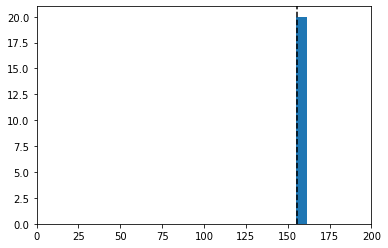

In [8]:
T_UPO_ref = 1.5586522107161747275678702092126960705284
plt.hist(np.hstack(wsizes),bins=50)
plt.xlim(0,200)
plt.axvline(T_UPO_ref/dt,c='k',ls='--')
plt.axvline(T_UPO_ref*2/dt,c='k',ls='--')

plt.show()

In [9]:
t0,tf = np.vstack(windows)[np.argmin(np.hstack(wsizes))]
print((tf-t0)*dt)

1.5499999653548002


In [10]:
T_UPO = (tf-t0)*dt

In [11]:
delay = int(.1/dt)
print(delay)
lcs,P = op_calc.transition_matrix(labels_phspace,delay,return_connected=True)
inv_measure = op_calc.stationary_distribution(P)
final_labels = op_calc.get_connected_labels(labels_phspace,lcs)
n_modes=10
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(eigvals)
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked
phi2 = eigfunctions[:,1]

PF_eigvecs = op_calc.sorted_spectrum(R.T,k=n_modes)[1]
eigfunctions_PF = PF_eigvecs.real/np.linalg.norm(PF_eigvecs.real,axis=0)

10


In [12]:
c_range,rho_sets,idx,kmeans_labels = op_calc.optimal_partition(phi2,inv_measure,P,return_rho=True)

# FigS6b

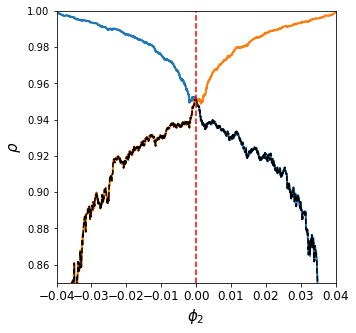

In [13]:
plt.figure(figsize=(5,5))
plt.plot(c_range,rho_sets,lw=2)
rho_c = np.min(rho_sets,axis=1)
plt.plot(c_range,rho_c,c='k',ls='--')
plt.axvline(c_range[idx],c='r',ls='--')
plt.ylim(.85,1)
plt.xlim(-0.04,0.04)
plt.xlabel(r'$\phi_2$',fontsize=15)
plt.ylabel(r'$\rho$',fontsize=15)
plt.xticks(fontsize=12)
# plt.savefig('rho_Lorenz.pdf')
plt.show()

In [14]:
f = h5py.File(dir_path+'Lorenz/tscales_analysis/tscales_compute_{}_clusters.h5'.format(n_clusters),'r')
print(list(f.keys()))
ts_traj_delay = np.array(f['ts_traj_delay'])
delay_range = np.array(f['delay_range'])
length = int(np.array(f['seq_length'])[0])
f.close()

['delay_range', 'seq_length', 'ts_traj_delay']


In [15]:
tscale_kd = np.array([np.mean(ts_traj_delay[:,:,0],axis=0)[9],np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)[9],np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)[9]])

# Fig4b 

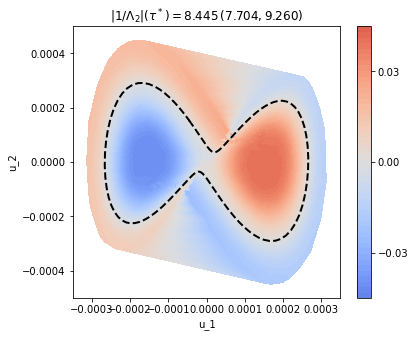

In [16]:
plt.figure(figsize=(6,5))
plt.title(r'$|1/\Lambda_2|(\tau^*) = {:.3f}\,({:.3f},{:.3f})$'.format(tscale_kd[0],tscale_kd[1],tscale_kd[2]))
plt.tricontourf(centers_phspace[:,0],centers_phspace[:,1],phi2,levels=np.linspace(-0.045,0.045,50),cmap='coolwarm',vmin=-0.06,vmax=0.06)#,cmap='seismic')
plt.plot(phspace[t0:tf+2,0],phspace[t0:tf+2,1],c='k',lw=2,ls='--')
plt.colorbar(ticks=np.linspace(-0.06,0.06,5))
plt.xlim(-3.5e-4,3.5e-4)
plt.ylim(-5e-4,5e-4)
plt.xlabel('u_1')
plt.ylabel('u_2')
# plt.savefig('Koopman_eigfun_Lorenz_phspace_coolwarm.pdf')
plt.show()

# FigS6b

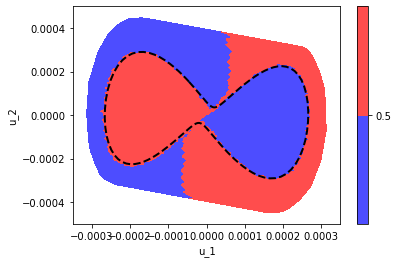

In [17]:
plt.tricontourf(centers_phspace[:,0],centers_phspace[:,1],kmeans_labels,levels=[-.2,0.5,1.2],cmap='seismic',vmin=-.5,vmax=1.5)#,levels=np.linspace(-0.07,0.07,50),cmap='seismic')#,cmap='seismic')
plt.plot(phspace[t0:tf+2,0],phspace[t0:tf+2,1],c='k',lw=2,ls='--')
plt.colorbar(ticks=[0.5])
plt.xlim(-3.5e-4,3.5e-4)
plt.ylim(-5e-4,5e-4)
plt.xlabel('u_1')
plt.ylabel('u_2')
# plt.savefig('labels_Lorenz_phspace.pdf')
plt.show()

# Fig4a

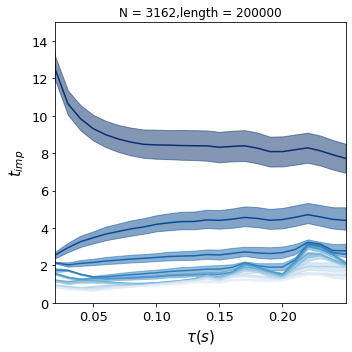

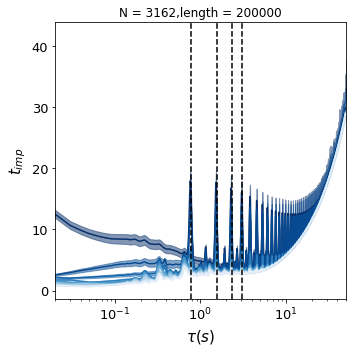

In [18]:
plt.figure(figsize=(5,5))

plt.title('N = {},length = {}'.format(n_clusters,length))

dmax = 25
for mode in range(n_modes):
    mean = np.mean(ts_traj_delay[:,:,mode],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,mode],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,mode],97.5,axis=0)
    plt.plot(delay_range[:dmax]*dt,mean[:dmax],c=colors_modes[mode])
    plt.fill_between(delay_range[:dmax]*dt,cil[:dmax],ciu[:dmax],alpha=.5,color=colors_modes[mode])
plt.xlim(2*dt,dmax*dt)
plt.ylim(0,15)
plt.ylabel('$t_{imp}$',fontsize=15,rotation=90)
plt.xlabel(r'$\tau (s)$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('tscales_Lorenz.pdf')

plt.show()

plt.figure(figsize=(5,5))

plt.title('N = {},length = {}'.format(n_clusters,length))


for mode in range(n_modes):
    mean = np.mean(ts_traj_delay[:,:,mode],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,mode],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,mode],97.5,axis=0)
    plt.plot(delay_range*dt,mean[:],c=colors_modes[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_modes[mode])
plt.xlim(2*dt,50)
# plt.ylim(0,15)
plt.xscale('log')
plt.ylabel('$t_{imp}$',fontsize=15,rotation=90)
plt.xlabel(r'$\tau (s)$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(T_UPO/2,ls='--',c='k')
plt.axvline(T_UPO,ls='--',c='k')
plt.axvline(1.5*T_UPO,ls='--',c='k')
plt.axvline(2*T_UPO,ls='--',c='k')
# plt.axvline(3*T_UPO,ls='--',c='k')
# plt.savefig('tscales_Lorenz.pdf')
plt.tight_layout()

plt.show()